<a href="https://colab.research.google.com/github/salmanromeo/MAE_3403_Computer_Methods_in_Analysis_and_Design/blob/main/lecture_8_Fast_Fourier_Transform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#####Generally, the Fourier transform is useful for transforming partial differential equations (PDEs) into ordinary differential equations (ODEs). Here, we will demonstrate the utility of the FFT to numerically solve a number of PDEs.

**1D heat equation using the Fast Fourier transform**

#####The heat equation is given by:
\begin{align}
  u_t = α^2u_{xx}
    \end{align}
#####where $u(t, x)$ is the temperature distribution in time and space. If here Fourier transform in space, then $𝓕(u(t, x)) = û(t, w)$. The PDE becomes:
\begin{align}
  û_t = -α^2 \omega^2 û
    \end{align}
#####since the two spatial derivatives contribute $(i\omega)^2 = -\omega^2$ in the Fourier transform domain. Thus, by taking the Fourier transform, the PDE becomes an ODE for each fixed frequency $\omega$. The solution is given by:
\begin{align}
  û(t, w) = e^{-α^2 \omega^2t} û(0, w)
    \end{align}
#####The function $û(0, w)$ is the Fourier transform of the initial temperature distribution $u(0, x)$. It is now clear that higher frequencies, corresponding to larger values of $w$, decay more rapidly as time evolves, so that sharp corners in the temperature distribution rapidly smooth out.

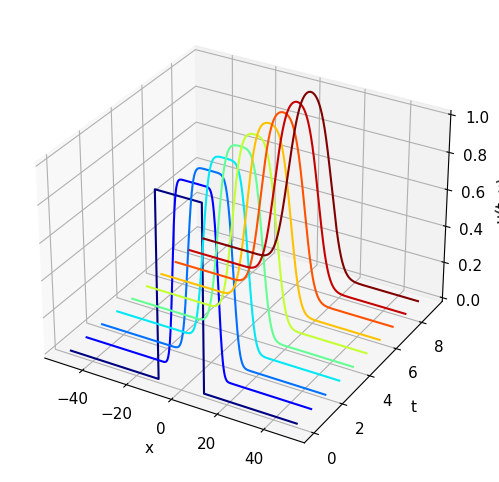

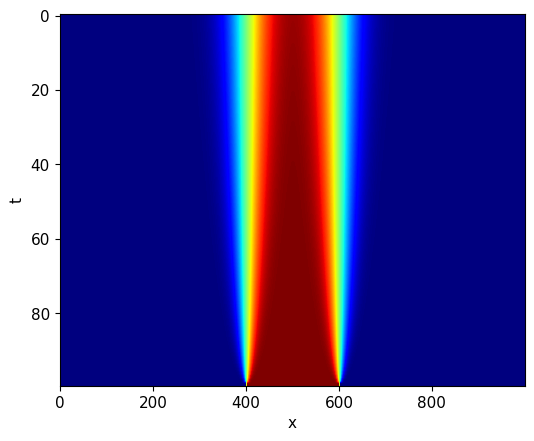

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import axes3d
plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams.update({'font.size': 11})

a = 1                      # Thermal diffusivity constant
L = 100                    # Length of domain
N = 1000                   # Number of discretization points
dx = L/N
x = np.arange(-L/2,L/2,dx) # Define x domain

# Define discrete wavenumbers
kappa = 2*np.pi*np.fft.fftfreq(N, d=dx)

# Initial condition
u0 = np.zeros_like(x)
u0[int((L/2 - L/10)/dx):int((L/2 + L/10)/dx)] = 1
u0hat = np.fft.fft(u0)

# SciPy's odeint function doesn't play well with complex numbers, so we recast 
# the state u0hat from an N-element complex vector to a 2N-element real vector
u0hat_ri = np.concatenate((u0hat.real,u0hat.imag))

# Simulate in Fourier frequency domain
dt = 0.1
t = np.arange(0,10,dt)

def rhsHeat(uhat_ri,t,kappa,a):
    uhat = uhat_ri[:N] + (1j) * uhat_ri[N:]
    d_uhat = -a**2 * (np.power(kappa,2)) * uhat
    d_uhat_ri = np.concatenate((d_uhat.real,d_uhat.imag)).astype('float64')
    return d_uhat_ri

uhat_ri = odeint(rhsHeat, u0hat_ri, t, args=(kappa,a))

uhat = uhat_ri[:,:N] + (1j) * uhat_ri[:,N:]

u = np.zeros_like(uhat)

for k in range(len(t)):
    u[k,:] = np.fft.ifft(uhat[k,:])

u = u.real    

# Waterfall plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

u_plot = u[0:-1:10,:]
for j in range(u_plot.shape[0]):
    ys = j*np.ones(u_plot.shape[1])
    ax.plot(x,ys,u_plot[j,:],color=cm.jet(j*30))
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u(t, x)')
    
# Image plot
plt.figure()
plt.xlabel('x')
plt.ylabel('t')
plt.imshow(np.flipud(u), aspect=8)
plt.set_cmap('jet')
plt.axis('on')
plt.show()

**1D wave equation using the Fast Fourier transform**

As second example is the simple linear PDE for the one-way equation:
\begin{align}
  u_t + cu_{x} = 0
    \end{align}

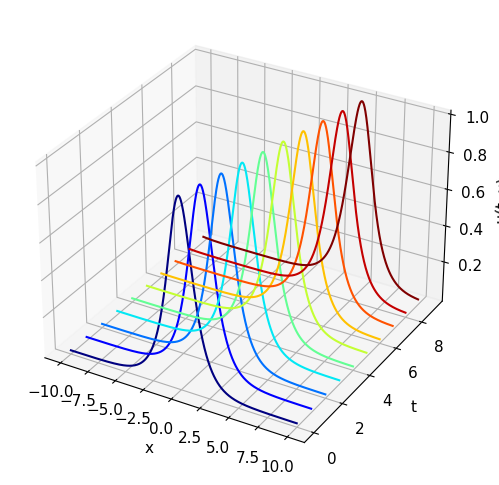

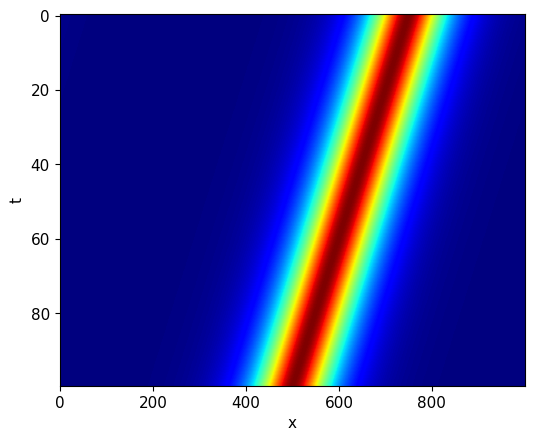

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import axes3d
plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams.update({'font.size': 11})

c = 2                       # Wave speed
L = 20                      # Length of domain
N = 1000                    # Number of discretization points
dx = L/N
x = np.arange(-L/2,L/2,dx)  # Define x domain

# Define discrete wavenumbers
kappa = 2*np.pi*np.fft.fftfreq(N, d=dx)

# Initial condition
u0 = 1/np.cosh(x)
u0hat = np.fft.fft(u0)

# SciPy's odeint function doesn't play well with complex numbers, so we recast 
# the state u0hat from an N-element complex vector to a 2N-element real vector
u0hat_ri = np.concatenate((u0hat.real,u0hat.imag))

# Simulate in Fourier frequency domain
dt = 0.025
t = np.arange(0,100*dt,dt)

def rhsWave(uhat_ri,t,kappa,c):
    uhat = uhat_ri[:N] + (1j) * uhat_ri[N:]
    d_uhat = -c*(1j)*kappa*uhat
    d_uhat_ri = np.concatenate((d_uhat.real,d_uhat.imag)).astype('float64')
    return d_uhat_ri

uhat_ri = odeint(rhsWave, u0hat_ri, t, args=(kappa,c))
uhat = uhat_ri[:,:N] + (1j) * uhat_ri[:,N:]

# Alternatively, simulate in spatial domain
def rhsWaveSpatial(u,t,kappa,c):
    uhat = np.fft.fft(u)
    d_uhat = (1j)*kappa*uhat
    d_u = np.fft.ifft(d_uhat).real
    du_dt = -c*d_u
    return du_dt

u = odeint(rhsWaveSpatial,u0,t,args=(kappa,c))

# Inverse FFT to bring back to spatial domain
u = np.zeros_like(uhat)

for k in range(len(t)):
    u[k,:] = np.fft.ifft(uhat[k,:])

u = u.real   

# Waterfall plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

u_plot = u[0:-1:10,:]
for j in range(u_plot.shape[0]):
    ys = j*np.ones(u_plot.shape[1])
    ax.plot(x,ys,u_plot[j,:],color=cm.jet(j*30))
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u(t, x)')
    
# Image plot
plt.figure()
plt.xlabel('x')
plt.ylabel('t')
plt.imshow(np.flipud(u), aspect=8)
plt.set_cmap('jet')
plt.axis('on')
plt.show()

**1D Burgers’ equation using the Fast Fourier transform**

#####For the final example, we consider the nonlinear Burgers’ equation
\begin{align}
  u_t + uu_{x} = 𝛎u_{xx}
    \end{align}
#####which is a simple 1D example for the nonlinear convection and diffusion that gives rise to shock waves in fluids.

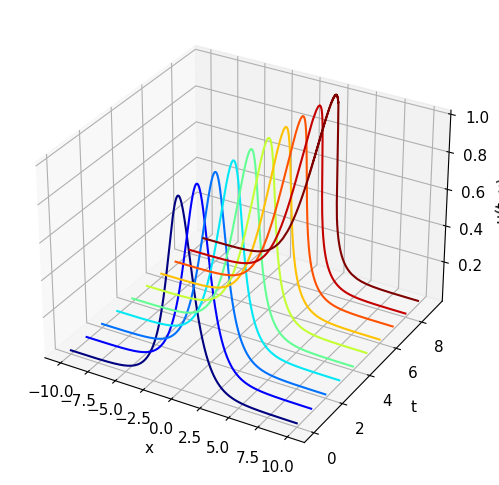

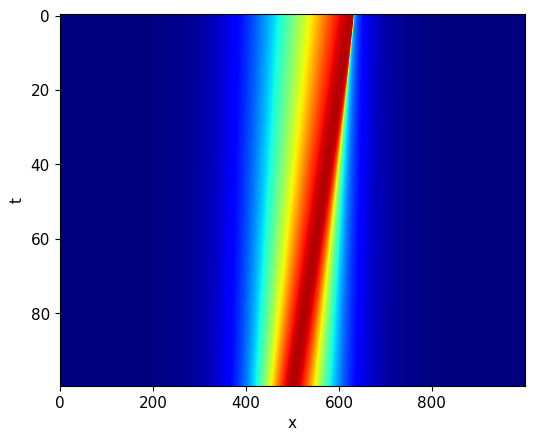

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import axes3d
plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams.update({'font.size': 11})

nu = 0.001                   # Diffusion constant
L = 20                       # Length of domain
N = 1000                     # Number of discretization points
dx = L/N
x = np.arange(-L/2,L/2,dx)   # Define x domain

# Define discrete wavenumbers
kappa = 2*np.pi*np.fft.fftfreq(N, d=dx)

# Initial condition
u0 = 1/np.cosh(x)

# Simulate PDE in spatial domain
dt = 0.025
t = np.arange(0,100*dt,dt)

def rhsBurgers(u,t,kappa,nu):
    uhat = np.fft.fft(u)
    d_uhat = (1j)*kappa*uhat
    dd_uhat = -np.power(kappa,2)*uhat
    d_u = np.fft.ifft(d_uhat)
    dd_u = np.fft.ifft(dd_uhat)
    du_dt = -u * d_u + nu*dd_u
    return du_dt.real

u = odeint(rhsBurgers,u0,t,args=(kappa,nu))

# Waterfall plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

u_plot = u[0:-1:10,:]
for j in range(u_plot.shape[0]):
    ys = j*np.ones(u_plot.shape[1])
    ax.plot(x,ys,u_plot[j,:],color=cm.jet(j*30))
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u(t, x)')
    
# Image plot
plt.figure()
plt.xlabel('x')
plt.ylabel('t')
plt.imshow(np.flipud(u), aspect=8)
plt.set_cmap('jet')
plt.axis('on')
plt.show()